In [1]:
import anndata as ad
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy, lognorm, norm, gamma
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
# Double the default parameters
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 8
plt.rcParams['figure.constrained_layout.use'] = True
label_font = 20

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data

In [3]:
figprefix = 'figures/Klein_pure'
datadir = '/home/mffang/data/counts/Klein_2015/pure/'

In [4]:
pure_Klein = pd.read_csv('data/Klein/GSM1599501_K562_pure_RNA.csv')
Klein_genes = np.array(pure_Klein.to_numpy().T[0,],dtype=str)
pure_Klein

,Unnamed: 0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.943,0.944,0.945,0.946,0.947,0.948,0.949,0.950,0.951,0.952
0,A1BG,0,0,1,0,0,0,1,0,0,...,0,0,1,1,1,0,0,0,0,1
1,A1BG-AS1,0,1,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,A1CF,3,0,2,2,2,1,0,3,1,...,1,0,0,1,1,0,1,0,0,1
3,A2M,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
4,A2M-AS1,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25430,ZYG11A,1,2,1,1,1,1,1,1,2,...,0,0,0,0,0,0,1,0,0,1
25431,ZYG11B,0,1,2,2,3,3,1,4,0,...,1,0,0,1,3,4,0,2,1,0
25432,ZYX,2,7,1,3,2,2,1,2,2,...,1,2,2,2,3,4,2,2,3,4
25433,ZZEF1,2,1,0,1,0,1,1,0,1,...,1,2,0,1,0,0,1,1,0,0


In [5]:
pure = ad.read_h5ad(datadir + 'counts_unfiltered/adata.h5ad')
pure

AnnData object with n_obs × n_vars = 139957 × 39675
    layers: 'ambiguous', 'mature', 'nascent'

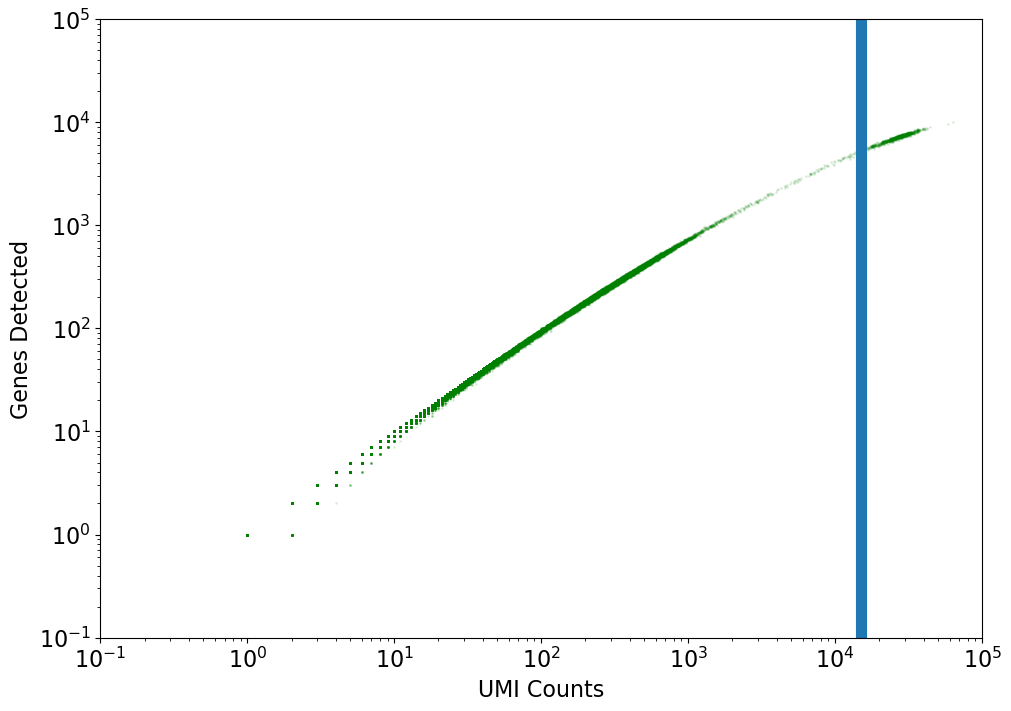

In [6]:
rna = pure.copy()

mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=1, alpha=0.1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.1,100000))
ax.set_ylim((0.1,100000))
ax.axvline(x=15000)
plt.show()

In [7]:
pure = rna[np.asarray(mtx.sum(axis=1))>15000]
pure

View of AnnData object with n_obs × n_vars = 916 × 39675
    layers: 'ambiguous', 'mature', 'nascent'

# Normalized covariance

In [8]:
adata = pure.copy()
adata.X = adata.layers['nascent'] + adata.layers['mature'] + adata.layers['ambiguous']
ERCC = adata[:,-92:]
adata = adata[:,:-92]
adata

View of AnnData object with n_obs × n_vars = 916 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

0.11886493 0.079894885 0.4618502


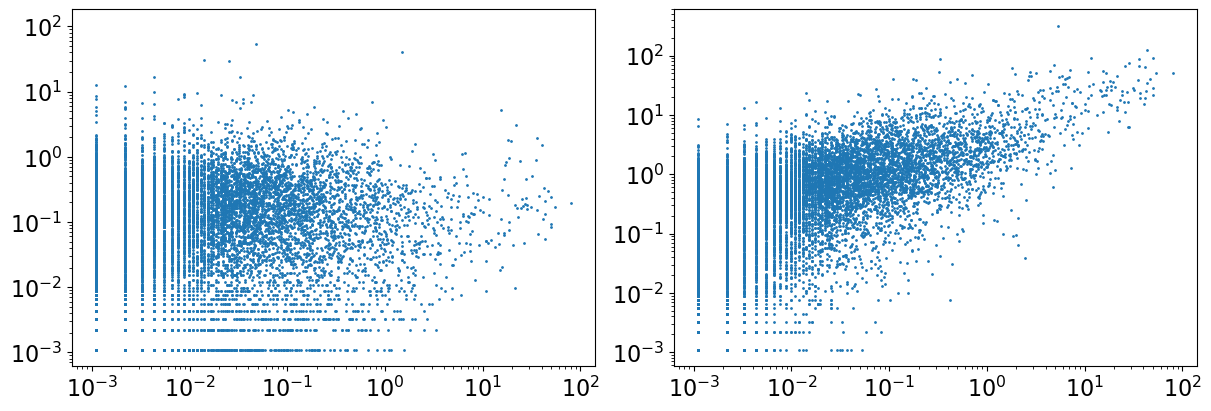

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

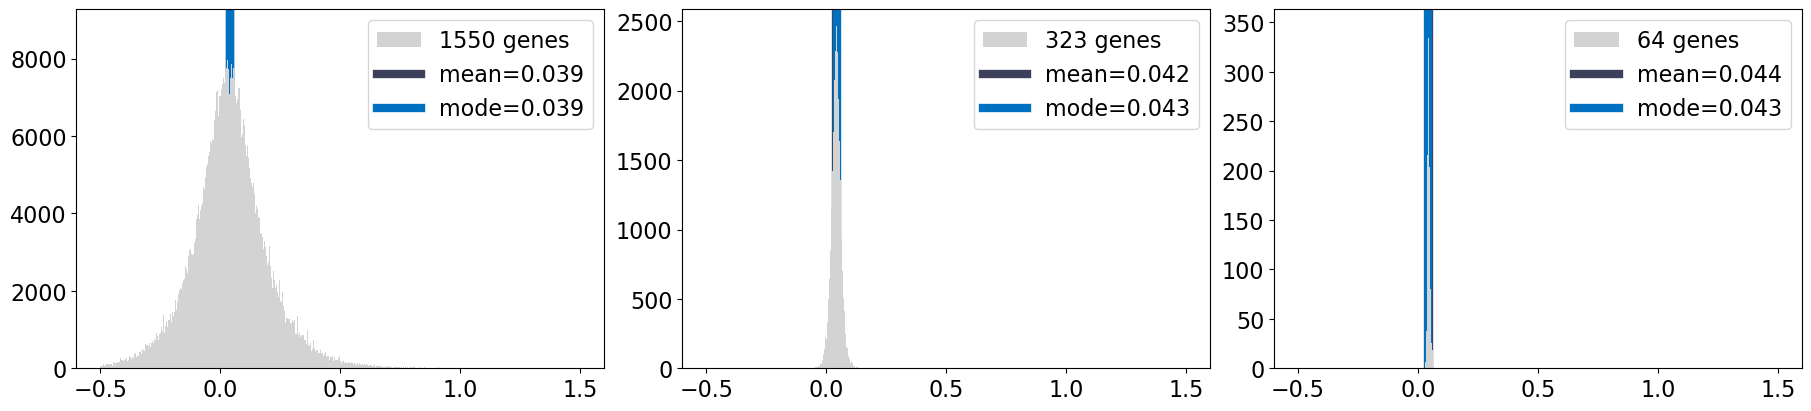

In [10]:
fig,axs = plt.subplots(1,3,figsize=(18,4))

s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(-0.5,1.5,0.001)-0.0005)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(-0.5,1.5,0.001)-0.0005)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[2],min_mean=10,bins=np.arange(-0.5,1.5,0.001)-0.0005)

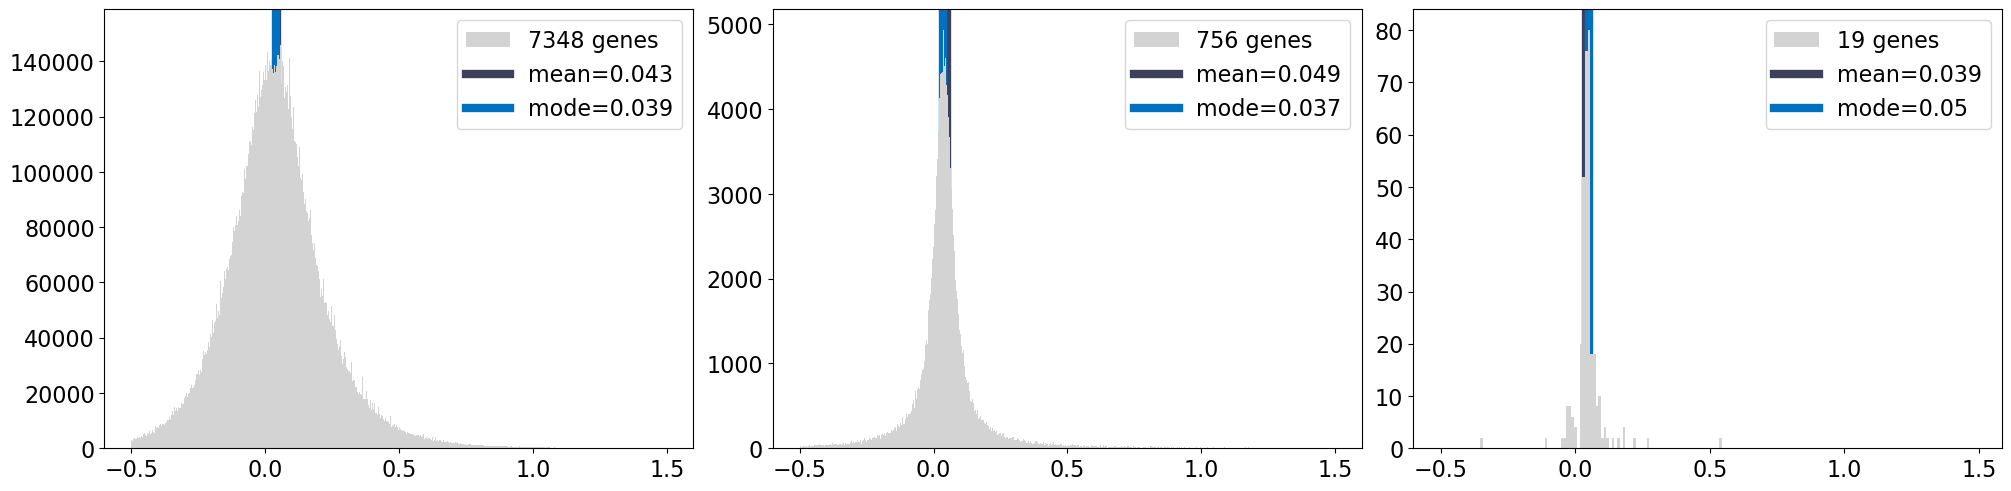

In [11]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(-0.5,1.5,0.001)-0.0005)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(-0.5,1.5,0.001)-0.0005)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=10)

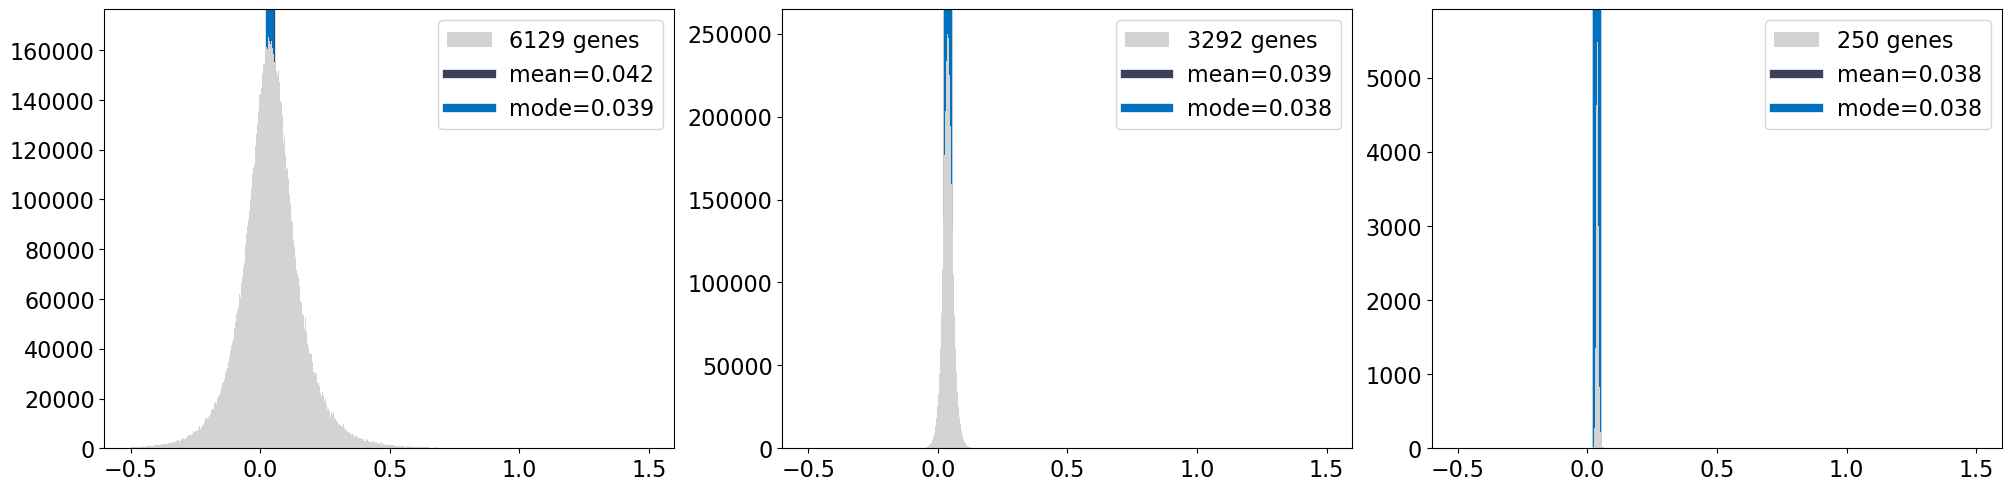

In [16]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(-0.5,1.5,0.001)-0.0005)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(-0.5,1.5,0.001)-0.0005)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[2],min_mean=10,bins=np.arange(-0.5,1.5,0.001)-0.0005)

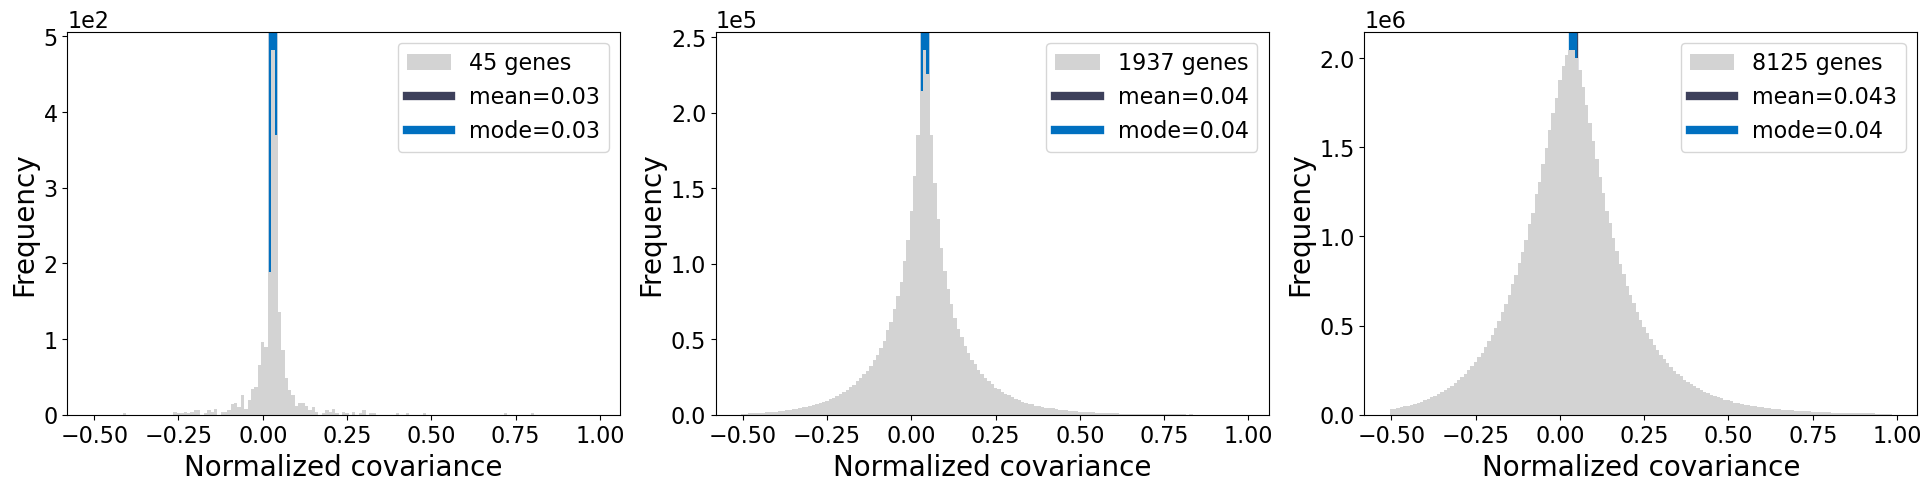

In [121]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s = estimate_s(N1=ERCC.X.toarray(),ax=axs[0],min_mean=0.1,bins=np.arange(-0.5,1.,0.01)-0.005)
s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=0.1,bins=np.arange(-0.5,1.,0.01)-0.005)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1,bins=np.arange(-0.5,1.,0.01)-0.005)


for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

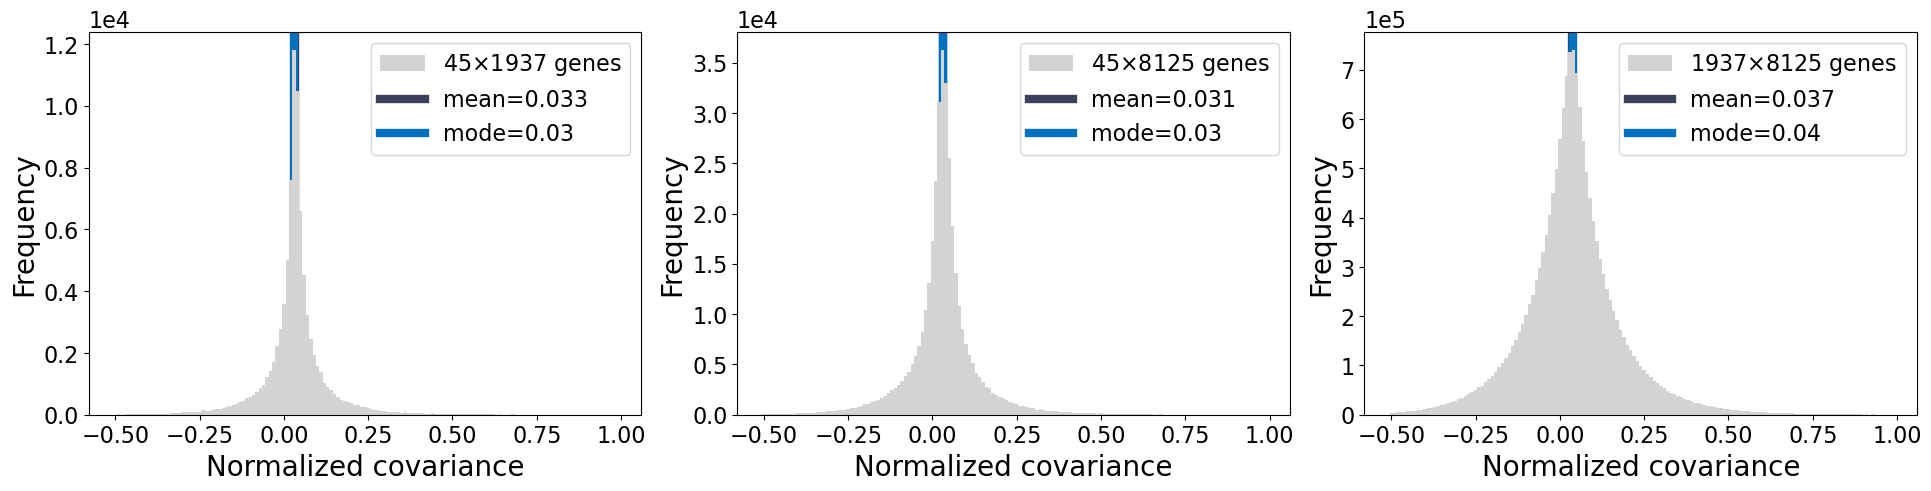

In [17]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s = estimate_s(N1=ERCC.X.toarray(),N2=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,bins=np.arange(-0.5,1.,0.01)-0.005)
s = estimate_s(N1=ERCC.X.toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=0.1,bins=np.arange(-0.5,1.,0.01)-0.005)
s = estimate_s(N1=adata.layers["mature"].toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1,bins=np.arange(-0.5,1.,0.01)-0.005)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

In [27]:
x=ERCC.X.toarray().sum(1)
print(x.var()/x.mean()**2)
x=adata.layers['mature'].toarray().sum(1)
print(x.var()/x.mean()**2)
x=adata.layers['nascent'].toarray().sum(1)
print(x.var()/x.mean()**2)
x=adata.X.toarray().sum(1)
print(x.var()/x.mean()**2)

0.03380042898992739
0.042277512766105814
0.04411324943591847
0.03858909286257402


# Varaince plot

In [18]:
se = 0.03
su = 0.04
ss = 0.04
sa = 0.04

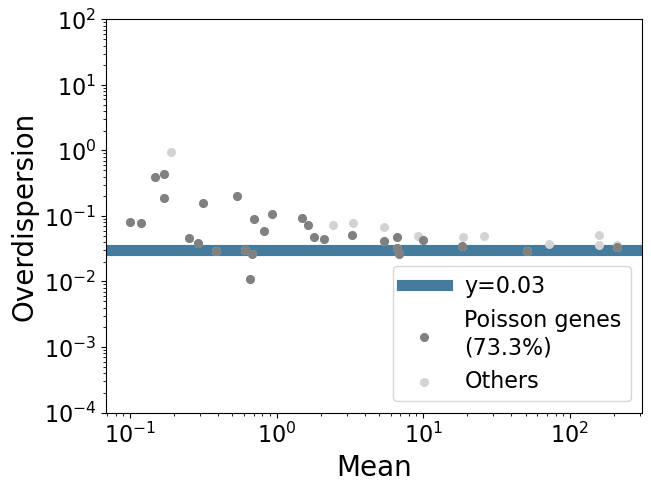

In [20]:
s = se
X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=10)
E_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = E_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

In [21]:
s = ss
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=10)
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = S_Pgene_mask.copy()

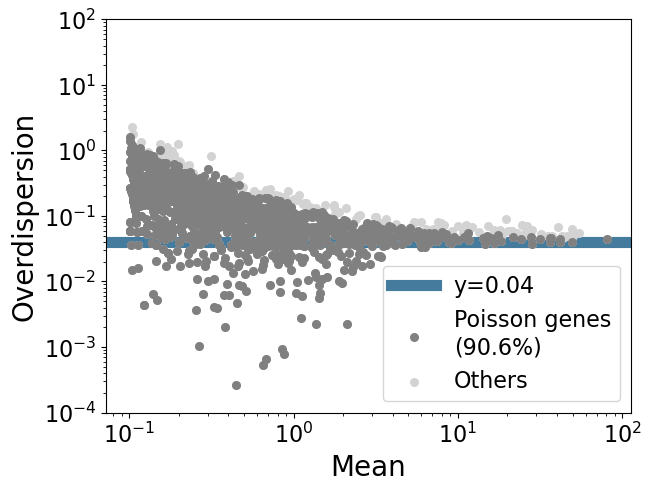

In [22]:
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

In [23]:
s = su
X_ = adata.layers['nascent'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=10)
U_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = U_Pgene_mask.copy()

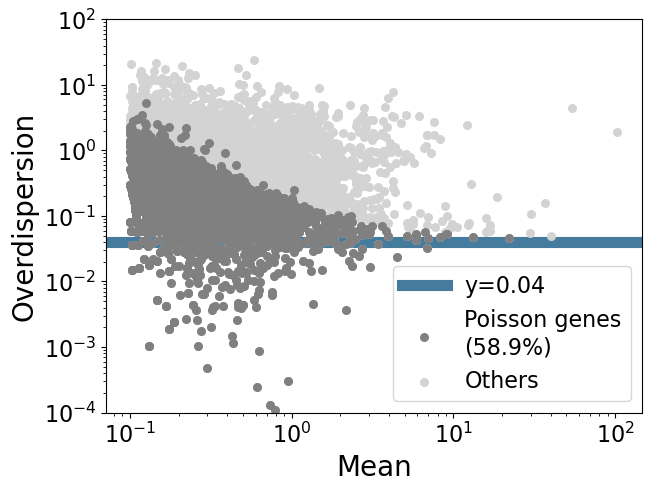

In [24]:
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

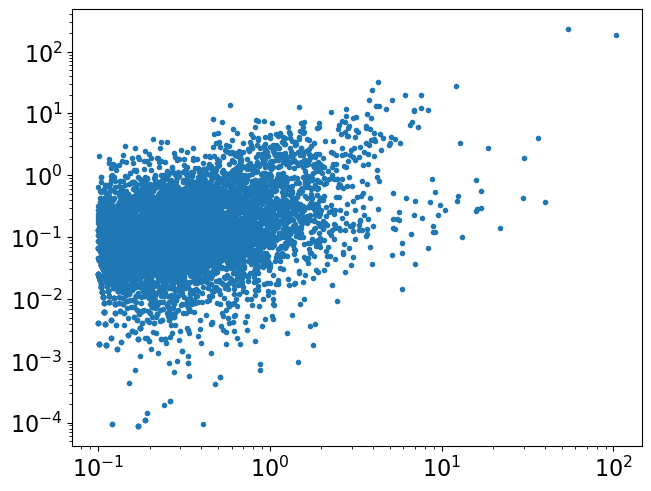

In [11]:
X_ = adata.layers['nascent'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

plt.loglog(X_mean,((X_var-X_mean)/X_mean**2 - su)*X_mean/(1+su),'.')

In [21]:
def calculate_gene_length(gtf_file):
    gene_lengths = {}

    with open(gtf_file, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue  # Skip header lines
            fields = line.strip().split('\t')
            if fields[2] == 'gene':
                gene_id = fields[8].split(';')[0].split('"')[1]
                start = int(fields[3])
                end = int(fields[4])
                length = end - start + 1  # Add 1 to include both start and end positions
                if gene_id not in gene_lengths:
                    gene_lengths[gene_id] = length
                else:
                    gene_lengths[gene_id] += length

    return gene_lengths
    
gene_lengths = calculate_gene_length("/home/mffang/data/ref/human/GRCh38.110_ERCC/Homo_sapiens.GRCh38.110_ERCC92.gtf")

In [23]:
adata.var['gene'] = np.array([gid.split('.')[0] for gid in adata.var_names],dtype=str)
adata.var

/tmp/ipykernel_3190431/1695384437.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene'] = np.array([gid.split('.')[0] for gid in adata.var_names],dtype=str)


,gene
gene_id,
ENSG00000228037.1,ENSG00000228037
ENSG00000142611.17,ENSG00000142611
ENSG00000284616.1,ENSG00000284616
ENSG00000157911.11,ENSG00000157911
ENSG00000260972.1,ENSG00000260972
...,...
ENSG00000275063.1,ENSG00000275063
ENSG00000277856.1,ENSG00000277856
ENSG00000271254.7,ENSG00000271254


In [27]:
adata.var['gene_length'] = np.array([gene_lengths[gid] for gid in adata.var['gene']],dtype=int)
adata.var

,gene,gene_length
gene_id,,
ENSG00000228037.1,ENSG00000228037,2974
ENSG00000142611.17,ENSG00000142611,369454
ENSG00000284616.1,ENSG00000284616,5467
ENSG00000157911.11,ENSG00000157911,9834
ENSG00000260972.1,ENSG00000260972,1697
...,...,...
ENSG00000275063.1,ENSG00000275063,433
ENSG00000277856.1,ENSG00000277856,294
ENSG00000271254.7,ENSG00000271254,25015


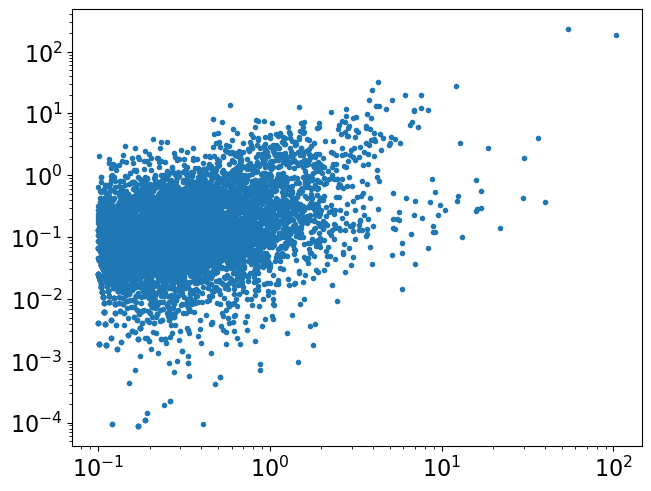

In [34]:
s=0.04
X_ = adata.layers['nascent'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

plt.loglog(X_mean,((X_var-X_mean)/X_mean**2 - su)*X_mean/(1+su),'.')

In [41]:
def normalized_variance(sampled_datasets,idx,eps=eta):
    """
    This function computes the normalized variance for the sampled datasets. 
    The normalized variance is defined as:
    
        eta = (variance - mean) / mean^2 - eps / mean
    
    Parameters
    ----------
    sampled_datasets : list of ndarray
        A list of 2D arrays (datasets), where each dataset represents a set of samples with features.
        Each dataset should have shape `(n_samples, n_features)`.
    
    eps : float or 1D array, optional, default=0
        A small constant to adjust the normalized variance formula. It can be used to prevent division by zero or
        to apply a bias to the calculated residue.

    Returns
    -------
    s : list of ndarray
        A list containing the normalized variance for each dataset in `sampled_datasets`.
        Each entry in the list corresponds to a dataset and has shape `(n_features,)`.
    """
    assert len(sampled_datasets)==1
    X = sampled_datasets[0][idx]
    assert len(np.shape(X))==2, "sampled_datasets needs to be a list of 2D arrays"
    bootstrap_var = X.var(axis=0)
    bootstrap_mean = X.mean(0)

    assert len(eps) == 1 or len(eps) == len(X[0])
    # Calculate residue (normalized variance)
    eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean
    
    return np.array(eta)

In [40]:
eta = np.array(1.04 * 1e-7 * adata.var['gene_length'][nonzero_idx])
lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=10)
U_Pgene_mask = (s < upper_bound) & (s > lower_bound)
Pgene_mask = U_Pgene_mask.copy()

array([0.00102274, 0.01648098, 0.00234374, ..., 0.00636854, 0.03469211,
       0.00302515])

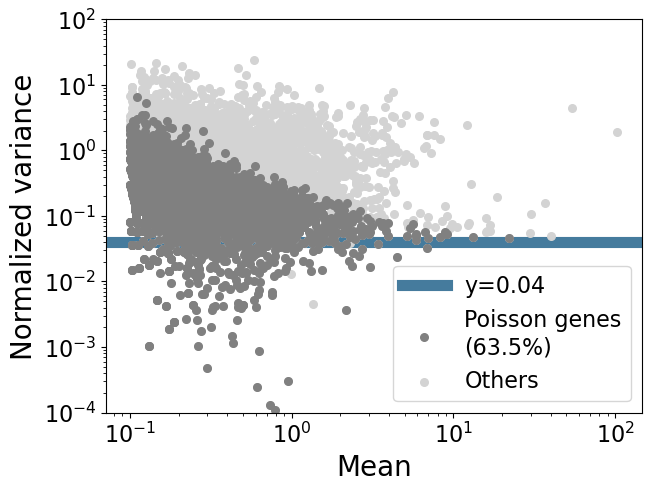

In [42]:
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

In [44]:
eta = np.array(1.04 * 1e-6 * adata.var['gene_length'][nonzero_idx])
lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=10)
U_Pgene_mask = (s < upper_bound) & (s > lower_bound)
Pgene_mask = U_Pgene_mask.copy()

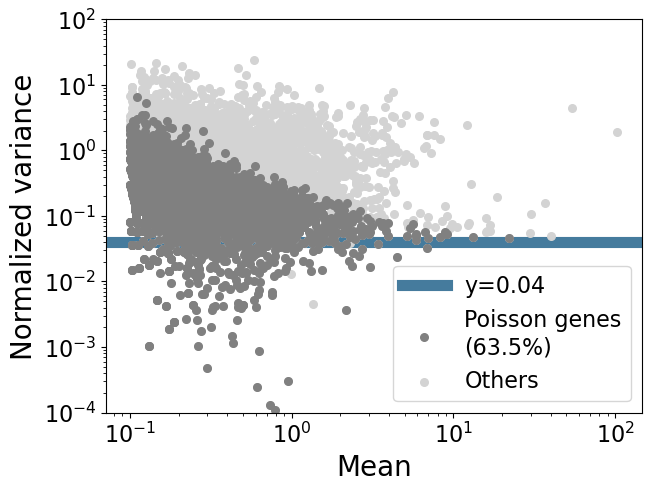

In [45]:
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

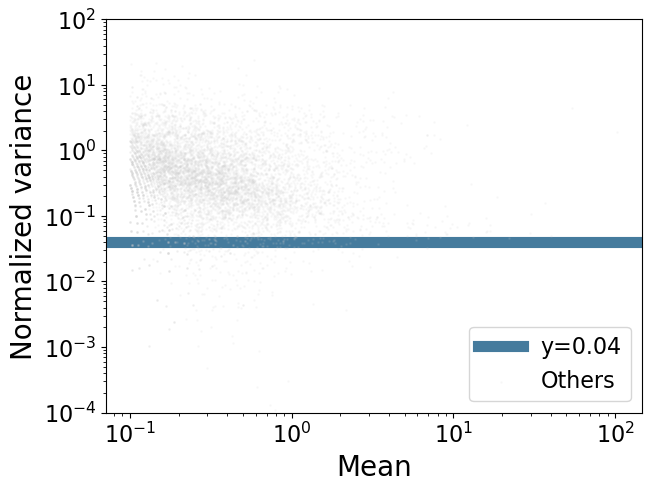

In [43]:
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=0.1, s=1, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

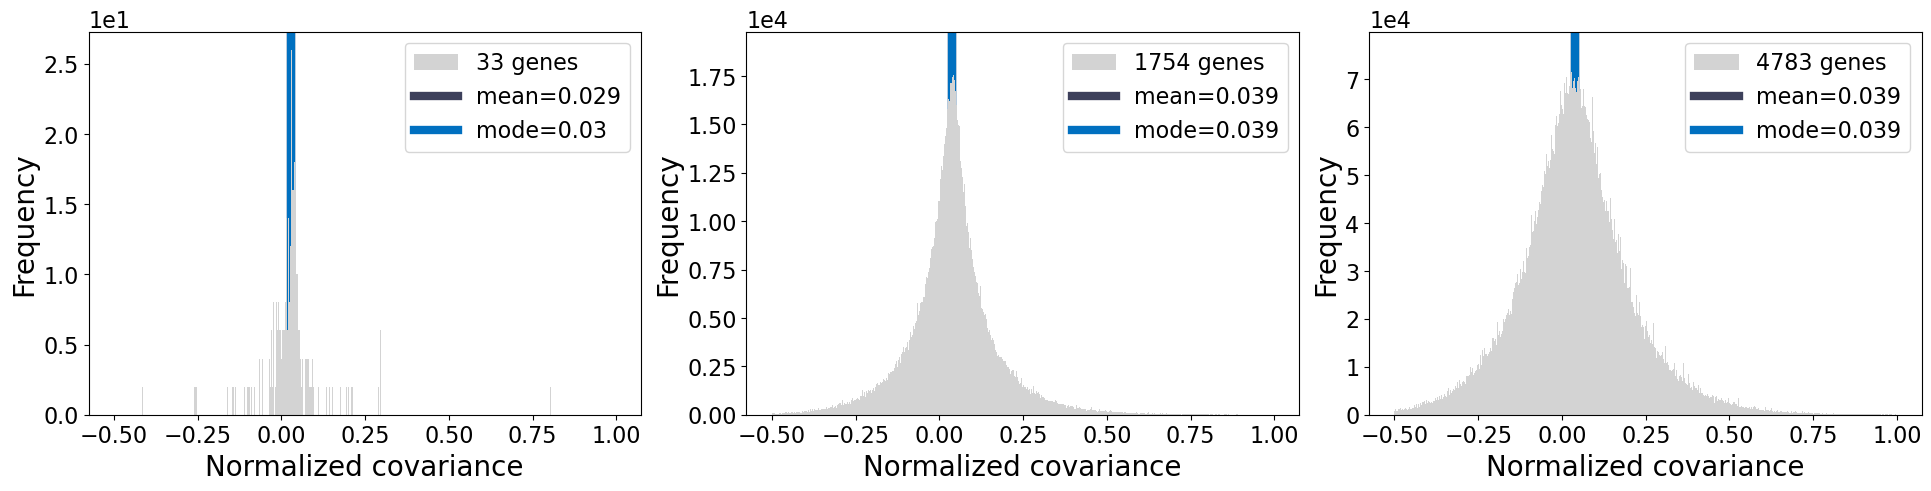

In [105]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
Pgene_mask = E_Pgene_mask.copy()
X_E = X_[:,nonzero_idx][:,Pgene_mask]
s = estimate_s(X_E,ax=axs[0],bins=np.arange(-0.5,1.,0.001)-0.0005)

X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
Pgene_mask = S_Pgene_mask.copy()
X_S = X_[:,nonzero_idx][:,Pgene_mask]
s = estimate_s(X_S,ax=axs[1],bins=np.arange(-0.5,1.,0.001)-0.0005)

X_ = adata.layers["nascent"].toarray()
nonzero_idx = X_.mean(0)>0.1
Pgene_mask = U_Pgene_mask.copy()
X_U = X_[:,nonzero_idx][:,Pgene_mask]
s = estimate_s(X_U,ax=axs[2],bins=np.arange(-0.5,1.,0.001)-0.0005)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

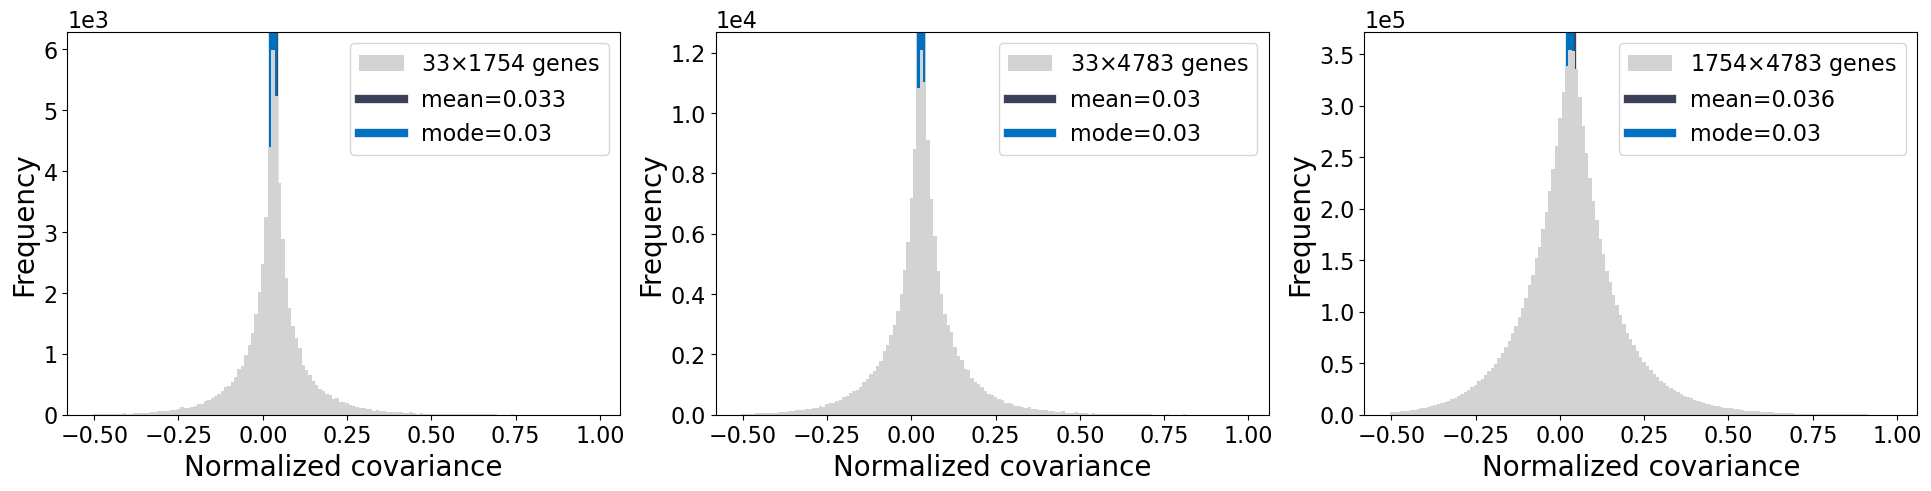

In [30]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s = estimate_s(N1=X_E,N2=X_S,ax=axs[0],bins=np.arange(-0.5,1.,0.01)-0.005)
s = estimate_s(N1=X_E,N2=X_U,ax=axs[1],bins=np.arange(-0.5,1.,0.01)-0.005)
s = estimate_s(N1=X_S,N2=X_U,ax=axs[2],bins=np.arange(-0.5,1.,0.01)-0.005)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

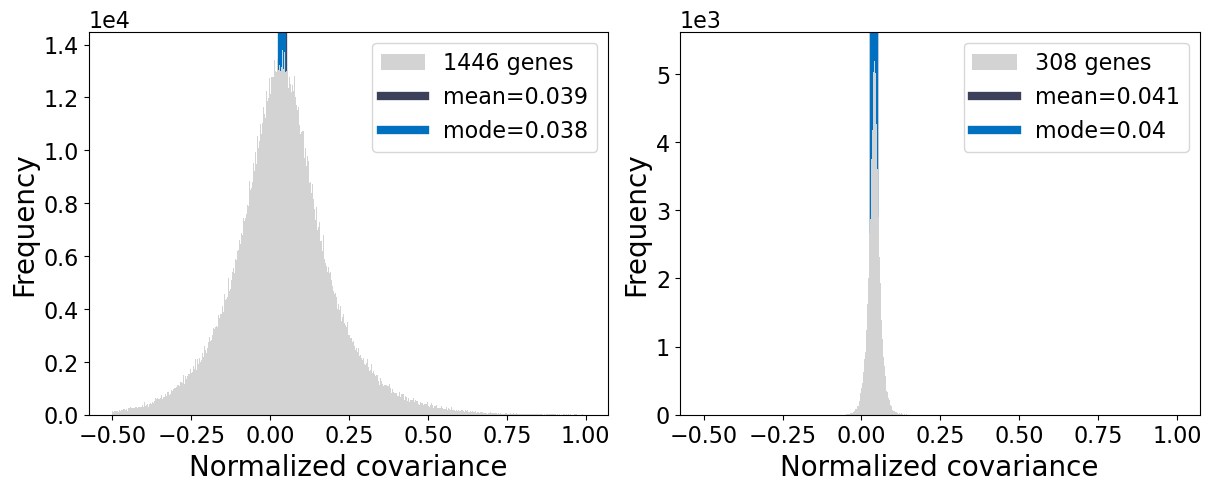

In [102]:
fig,axs = plt.subplots(1,2,figsize=(12,4.8))

s = estimate_s(N1=X_S,ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(-0.5,1.,0.002)-0.001)
s = estimate_s(N1=X_S,ax=axs[1],min_mean=1,bins=np.arange(-0.5,1.,0.002)-0.001)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

**Check over-dispersed genes**

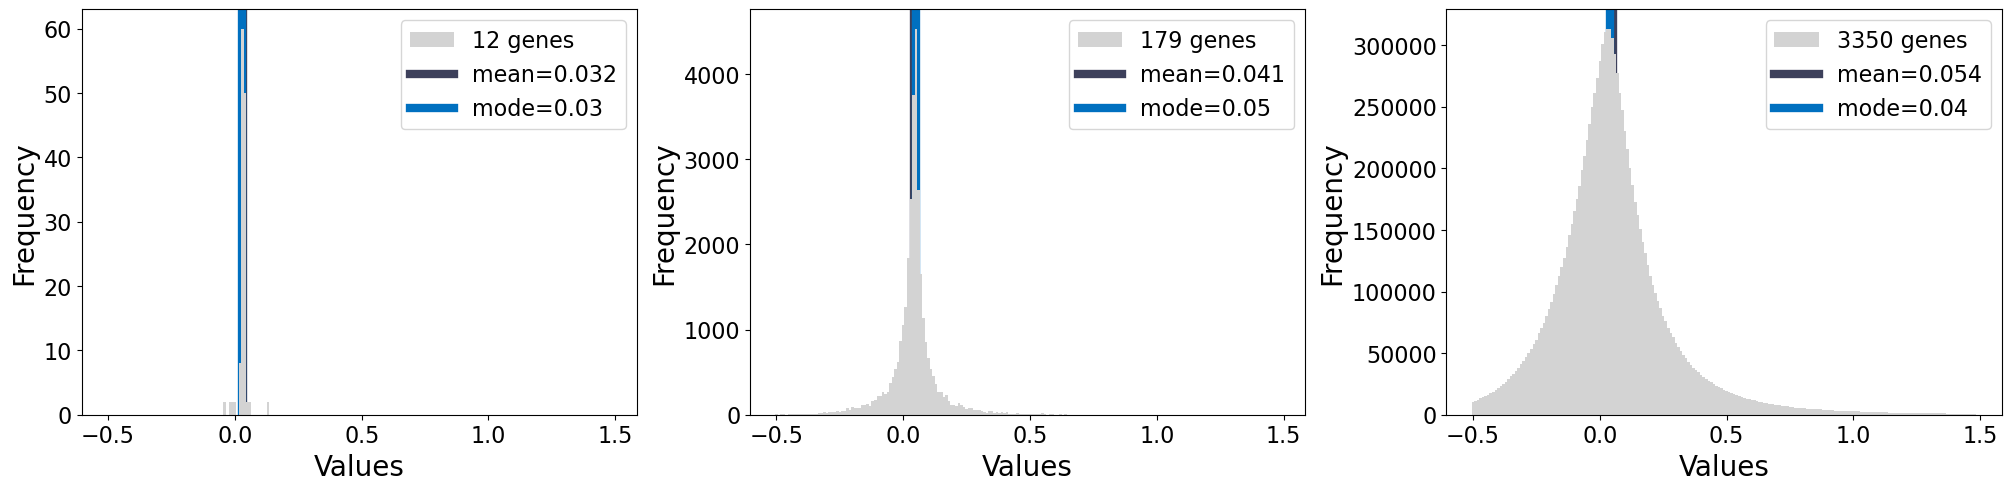

In [25]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
Pgene_mask = E_Pgene_mask.copy()
X_E = X_[:,nonzero_idx][:,~Pgene_mask]
s = estimate_s(X_E,ax=axs[0])

X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
Pgene_mask = S_Pgene_mask.copy()
X_S = X_[:,nonzero_idx][:,~Pgene_mask]
s = estimate_s(X_S,ax=axs[1])

X_ = adata.layers["nascent"].toarray()
nonzero_idx = X_.mean(0)>0.1
Pgene_mask = U_Pgene_mask.copy()
X_U = X_[:,nonzero_idx][:,~Pgene_mask]
s = estimate_s(X_U,ax=axs[2])

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

# Cell size

In [31]:
X_ = ERCC.X.toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_E = X_[:,E_Pgene_mask].sum(1)
print(E_Pgene_mask.sum())

X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_S = X_[:,S_Pgene_mask].sum(1)
print(S_Pgene_mask.sum())

X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_U = X_[:,U_Pgene_mask].sum(1)
print(U_Pgene_mask.sum())

cellsize_X = adata.X.toarray().copy().sum(1)

33
1754
4783


Text(0, 0.5, 'Using total counts')

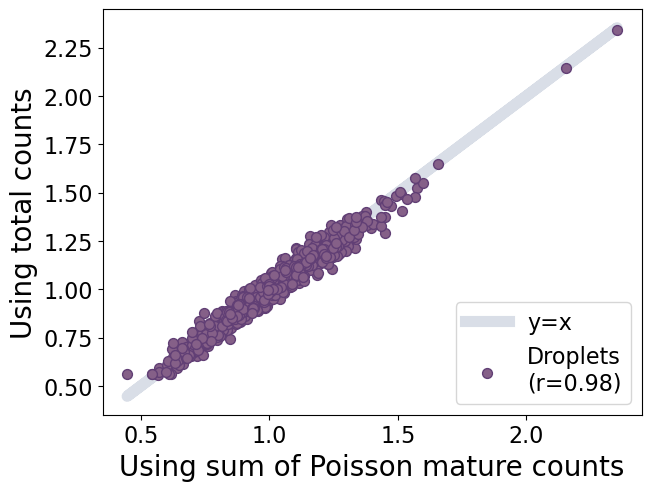

In [32]:
x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
ax.scatter(x,y,color='#856088',edgecolor='#613f75',alpha=1,s=50,\
           label='Droplets\n(r='+str(np.around(np.corrcoef(x,y)[0,1],2))+")")

plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Using sum of Poisson mature counts',fontsize=20)
plt.ylabel('Using total counts',fontsize=20)

Text(0, 0.5, 'Using total counts')

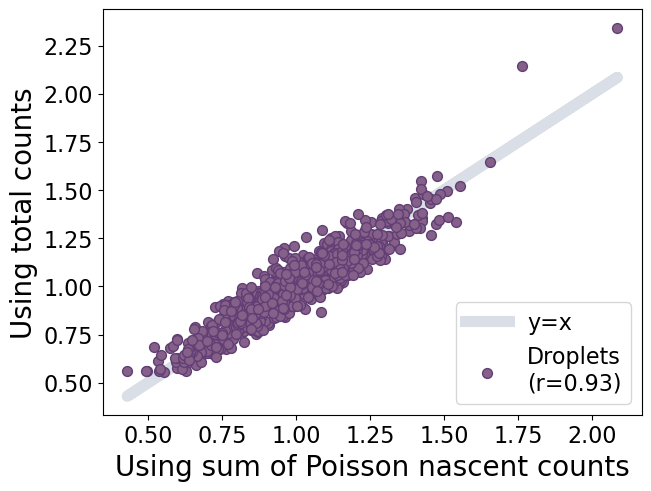

In [28]:
x = cellsize_U/cellsize_U.mean()
y = cellsize_X/cellsize_X.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
ax.scatter(x,y,color='#856088',edgecolor='#613f75',alpha=1,s=50,\
           label='Droplets\n(r='+str(np.around(np.corrcoef(x,y)[0,1],2))+")")

plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Using sum of Poisson nascent counts',fontsize=20)
plt.ylabel('Using total counts',fontsize=20)

Text(0, 0.5, 'Poisson nascent counts')

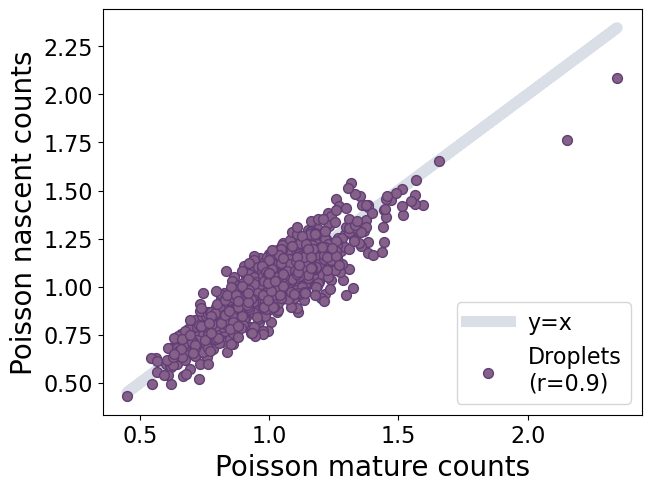

In [29]:
x = cellsize_S/cellsize_S.mean()
y = cellsize_U/cellsize_U.mean()
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
ax.scatter(x,y,color='#856088',edgecolor='#613f75',alpha=1,s=50,\
           label='Droplets\n(r='+str(np.around(np.corrcoef(x,y)[0,1],2))+")")

plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Poisson mature counts',fontsize=20)
plt.ylabel('Poisson nascent counts',fontsize=20)

Text(0, 0.5, 'Poisson ERCC counts')

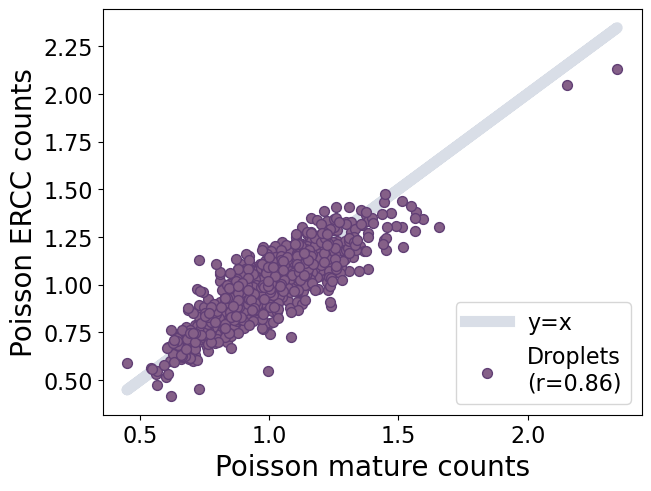

In [30]:
x = cellsize_S/cellsize_S.mean()
y = cellsize_E/cellsize_E.mean()
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
ax.scatter(x,y,color='#856088',edgecolor='#613f75',alpha=1,s=50,\
           label='Droplets\n(r='+str(np.around(np.corrcoef(x,y)[0,1],2))+")")

plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Poisson mature counts',fontsize=20)
plt.ylabel('Poisson ERCC counts',fontsize=20)

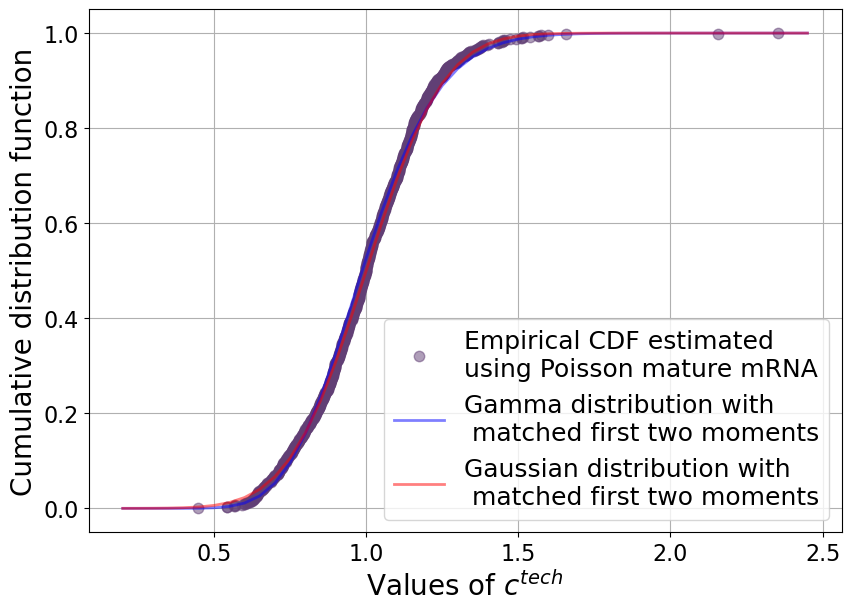

In [126]:
x = np.arange(0.2, 2.5, 0.05)
ds = cellsize_S / cellsize_S.mean()

# Plot empirical CDF
ds_sorted = np.sort(ds)
cdf = np.arange(1, len(ds_sorted) + 1) / len(ds_sorted)

plt.figure(figsize=(8.4,6))
plt.plot(ds_sorted, cdf, marker='.', linestyle='none', color='#613f75', alpha=0.5, markersize=15, label='Empirical CDF estimated\nusing Poisson mature mRNA')

# Plot theoretical Gamma CDF
plt.plot(x, gamma.cdf(x, a=1/ss, scale=ss), 'b-', zorder=10, linewidth=2, alpha=0.5, label='Gamma distribution with\n matched first two moments')

# Optional: Gaussian CDF (if needed)
plt.plot(x, norm.cdf(x, loc=1, scale=np.sqrt(ss)), 'r-', zorder=10, linewidth=2, alpha=0.5, label='Gaussian distribution with\n matched first two moments')

plt.legend(fontsize=18)
plt.ylabel('Cumulative distribution function', fontsize=20)
plt.xlabel(r'Values of $c^{tech}$', fontsize=20)
plt.grid(True)
plt.show()

# Simulation check

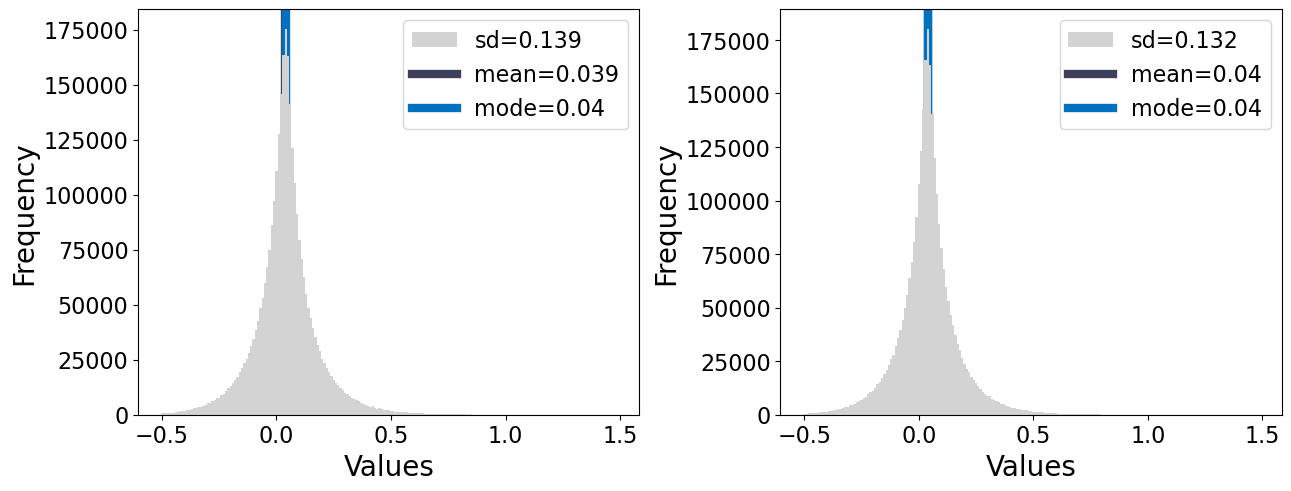

In [55]:
c = cellsize_S/cellsize_S.mean()
lam = X_S.mean(0)
np.random.seed(2025)
X_sim = np.random.poisson(c[:,None]*lam[None,:])

fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s_mm = estimate_s_(N1=X_S,ax=axs[0])
s_nn = estimate_s_(N1=X_sim,ax=axs[1])

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

In [80]:
def compute_eta(N1):
    X = N1
    X_mean = X.mean(0)
    eta = np.cov(X, rowvar=False) / X_mean[:, None] / X_mean[None, :]
    np.fill_diagonal(eta, np.nan)
    return eta[~np.isnan(eta)]

# Compute eta for measured data
eta_S = compute_eta(X_S)

# Simulate and compute eta for generative model
n_simulations = 1000
eta_sim_ecdfs = []

for _ in range(n_simulations):
    X_sim = np.random.poisson(c[:, None] * lam[None, :])
    eta_sim = compute_eta(X_sim)
    
    eta_sim_sorted = np.sort(eta_sim)
    ecdf_sim = np.arange(1, len(eta_sim_sorted) + 1) / len(eta_sim_sorted)
    
    # Interpolate onto common x-grid for consistency
    eta_grid = np.linspace(np.min(eta_S), np.max(eta_S), 500)
    ecdf_interp = np.interp(eta_grid, eta_sim_sorted, ecdf_sim, left=0, right=1)
    eta_sim_ecdfs.append(ecdf_interp)

eta_sim_ecdfs = np.array(eta_sim_ecdfs)

# Compute median and 95% CI across simulations
ecdf_median = np.median(eta_sim_ecdfs, axis=0)
ecdf_lower = np.percentile(eta_sim_ecdfs, 2.5, axis=0)
ecdf_upper = np.percentile(eta_sim_ecdfs, 97.5, axis=0)

# ECDF for real data
eta_S_sorted = np.sort(eta_S)
ecdf_S = np.arange(1, len(eta_S_sorted) + 1) / len(eta_S_sorted)

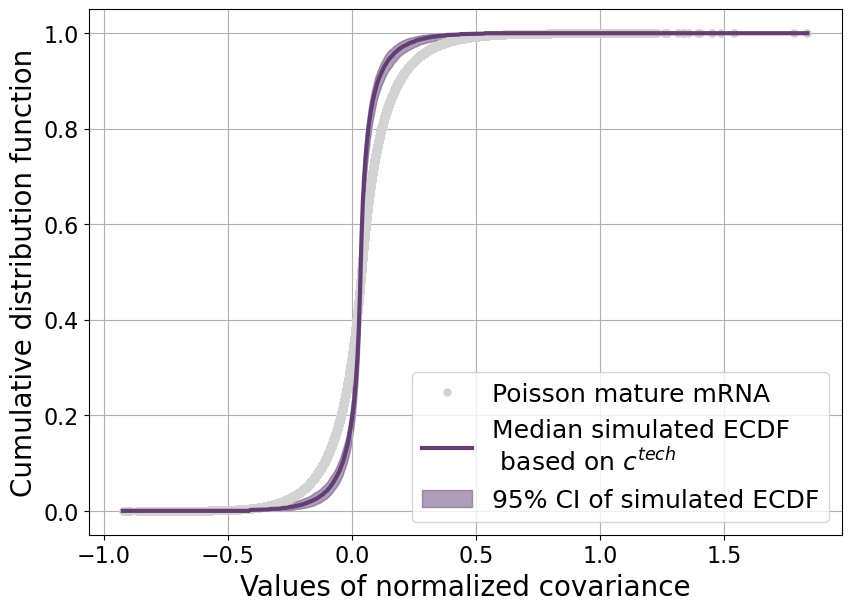

In [128]:
plt.figure(figsize=(8.4,6))

# Real data ECDF
plt.plot(eta_S_sorted, ecdf_S, marker='.', linestyle='none', color='lightgray', markersize=10, label=r'Poisson mature mRNA')
plt.legend(fontsize=18,markerscale=10.0)

# Median simulation ECDF
plt.plot(eta_grid, ecdf_median, linewidth=3, color='#613f75', label='Median simulated ECDF\n'+r' based on $c^{tech}$')

# 95% confidence band
plt.fill_between(eta_grid, ecdf_lower, ecdf_upper, color='#613f75', alpha=0.5, label='95% CI of simulated ECDF')

plt.xlabel('Values of normalized covariance', fontsize=20)
plt.ylabel('Cumulative distribution function', fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

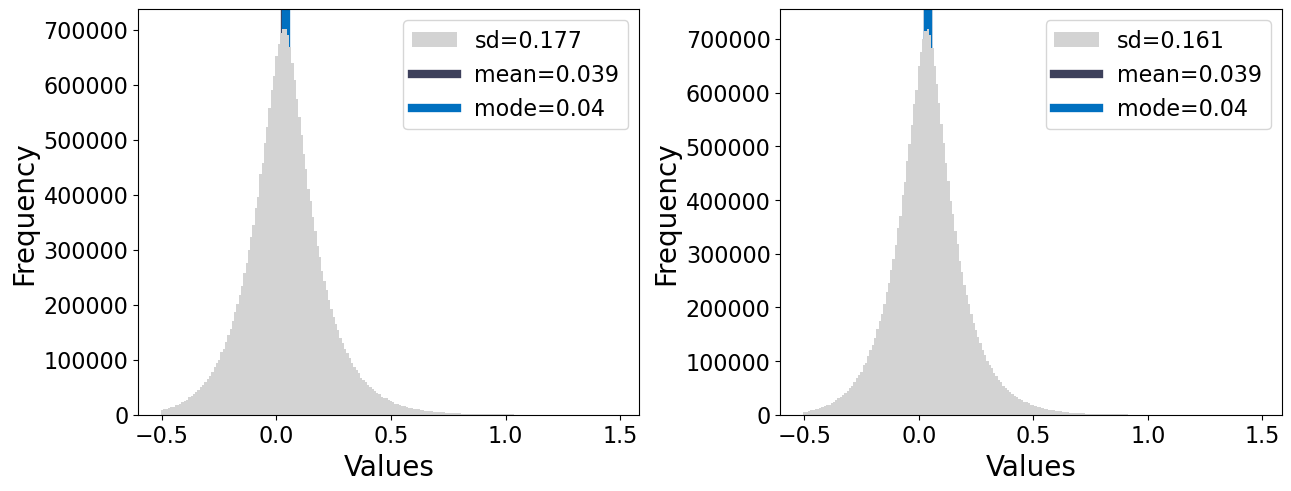

In [56]:
c = cellsize_U/cellsize_U.mean()
lam = X_U.mean(0)

np.random.seed(2025)
X_sim = np.random.poisson(c[:,None]*lam[None,:])

fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s_mm = estimate_s_(N1=X_U,ax=axs[0])
s_nn = estimate_s_(N1=X_sim,ax=axs[1])

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

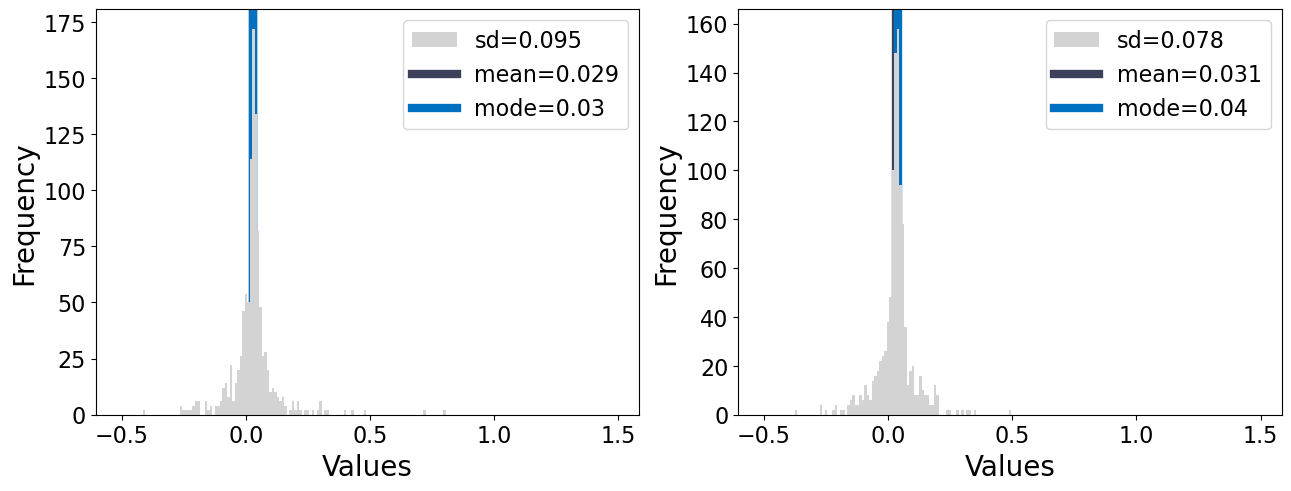

In [57]:
c = cellsize_E/cellsize_E.mean()
lam = X_E.mean(0)

np.random.seed(2025)
X_sim = np.random.poisson(c[:,None]*lam[None,:])

fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s_mm = estimate_s_(N1=X_E,ax=axs[0])
s_nn = estimate_s_(N1=X_sim,ax=axs[1])

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

# Covariance relationships

In [34]:
s_uu = s_ss = s_us = 0.04

idx = adata.var_names.isin(adata.var_names)

U = adata.layers["nascent"][:,idx].toarray()
S = adata.layers["mature"][:,idx].toarray() 

idx = (U.mean(0)>0.1) & (S.mean(0)>0.1)
U = U[:,idx]
S = S[:,idx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2-s_uu
zeta_ss = (S_var-S_mean)/S_mean**2-s_ss

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean-s_us
zeta_us.shape

(985,)

81.32% of 985 genes > 0


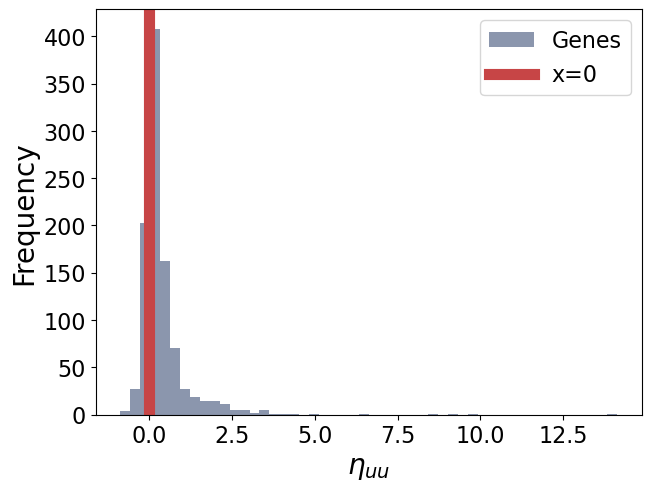

In [35]:
plt.figure(figsize=(6.4,4.8))
plt.hist(zeta_uu,bins=50,color=gray,label='Genes');
plt.axvline(x=0,c=red,label='x=0')
plt.xlabel(r'$\eta_{uu}$',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.legend();
print(str(np.around(100*(zeta_uu>0).mean(),2))+'% of '+str(len(zeta_uu))+' genes > 0')
#plt.savefig(figprefix+"_uu.pdf", dpi=150)

Pearson's r=-0.01, CCC=-0.0
78.68% of 985 genes above


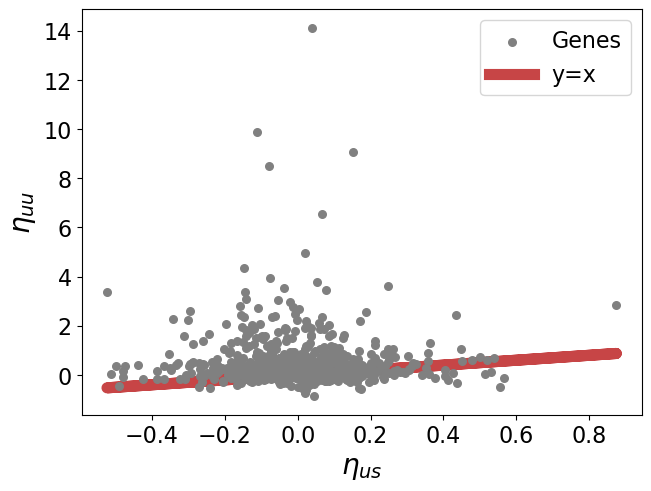

In [36]:
x=zeta_us
y=zeta_uu

plt.figure(figsize=(6.4,4.8))
plt.scatter(x,y,s=30,color='gray',label='Genes');
plt.plot(x,x,zorder=0,c=red, label='y=x')
print("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
print(str(np.around(100*(y>x).mean(),2))+'% of '+str(len(zeta_uu))+' genes above')
plt.legend()
plt.xlabel(r'$\eta_{us}$',fontsize=label_font);
plt.ylabel(r'$\eta_{uu}$',fontsize=label_font);
#plt.savefig(figprefix+"_us.pdf", dpi=150)

In [37]:
lower_bound, upper_bound, delta_eta_bootstrap = bootstrapping_func(delta_eta,[U,S],B=1000,n_cores=50)
delta_eta_bootstrap

array([[ 0.14716548,  1.0270497 , -0.13400066, ..., -0.41359574,
         0.40606827, -0.62698644],
       [ 0.10177979,  0.64662296, -0.02908104, ...,  0.03693151,
         0.0518412 ,  0.11775281],
       [ 0.04300886,  0.49739847,  0.3080262 , ..., -0.34648293,
        -0.5623827 ,  0.07530575],
       ...,
       [ 0.06420459,  0.1739371 , -0.2063037 , ..., -0.17776474,
        -0.07420437,  0.31139585],
       [ 0.03177632,  0.29338259, -0.00782492, ..., -0.22652632,
         0.2428788 , -0.09666675],
       [ 0.13431501,  1.0769763 ,  0.04979397, ..., -0.4807365 ,
         0.5523835 ,  0.19987957]], dtype=float32)

In [38]:
Null_gene_mask = (0 < upper_bound) & (0 > lower_bound) 
Null_gene_mask.mean()

0.932994923857868

Pearson's r=0.053, CCC=0.045


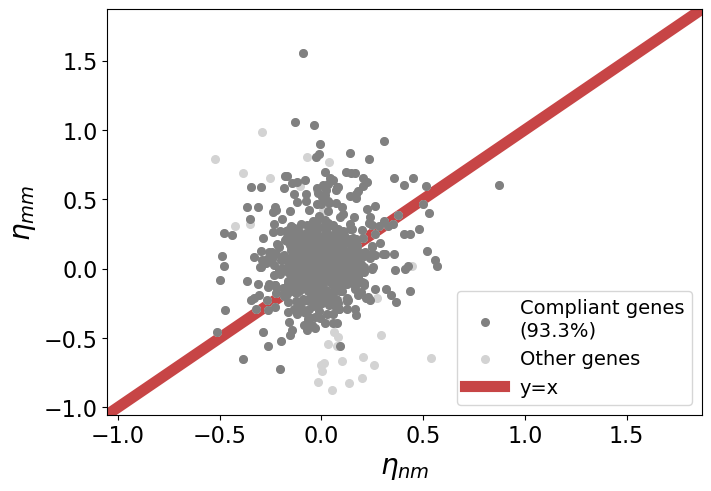

In [39]:
x=zeta_us
y=zeta_ss

all_data = np.concatenate([x, y])
min_val, max_val = all_data.min()*1.2, all_data.max()*1.2

plt.figure(figsize=(7,4.8))
plt.scatter(x[Null_gene_mask],y[Null_gene_mask],s=30,zorder=2,color='gray',label='Compliant genes\n('+str(np.around(100*np.mean(Null_gene_mask),1))+"%)")
plt.scatter(x,y,s=30,color='lightgray',zorder=1,label='Other genes')
plt.plot([min_val, max_val],[min_val, max_val],zorder=0,c=red,label='y=x')
plt.legend(loc='lower right',fontsize=14);
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel(r'$\eta_{nm}$',fontsize=20);
plt.ylabel(r'$\eta_{mm}$',fontsize=20);
#plt.savefig(figprefix+"_us.pdf", dpi=150)
print("Pearson's r="+str(np.round(pearsonr(x,y).statistic,3))+", CCC="+str(np.round(CCC(x,y),3)))